In [1]:
import gym
import numpy as np
from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

Using TensorFlow backend.


In [2]:
env = gym.make("CartPole-v1")


In [3]:
print("Understanding the Environment")
print("\n")
print("Action Space: ",env.action_space)
print("State Space: ",env.observation_space)
print("State Example: ",env.reset())
print("Cycle tuple Example: ",env.step(0))

Understanding the Environment


Action Space:  Discrete(2)
State Space:  Box(4,)
State Example:  [ 0.00383474  0.04873618  0.02552966 -0.02176892]
Cycle tuple Example:  (array([ 0.00480946, -0.14674241,  0.02509428,  0.27885833]), 1.0, False, {})


Bellman Equation:

The expected reward for being in a particular state s and following action prescribed by some policy is eqaul:

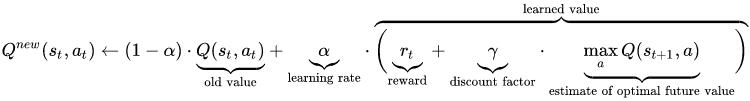

In [15]:
class My_DQN_Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=2000)
        
        self.e = 1.000
        self.e_decay = 0.999
        self.e_min = 0.001
        
        self.learning_rate = 0.01
        self.discount_rate = 0.90
        
        self.model = self.build_model()
        
    def build_model(self):
        
        model = Sequential()
        
        model.add(Dense(16, input_dim=self.state_size, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss = "mse", optimizer = Adam(lr=self.learning_rate))
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def select_action(self, state):
        # Pick random Action if rand less than epsilon
        if np.random.rand() <= self.e:
            return np.random.randint(0,self.action_size)
        
        # Otherwise, use the current best options as action
        
        all_q_values = self.model.predict(state)
        return np.argmax(all_q_values[0])
    
    def replay(self, batch_size):
        
        #This will take (batch_size) number of (self.memory) as a mini_batch
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            if done:
                # if it has terminate, reward is just the final reward.
                target = reward
            else:
                # if it has next_state, use the bellman equation to calculate the reward
                
                target = reward + self.discount_rate * np.max(self.model.predict(next_state)[0])
            
            # Now I replay this piece on memory, get the result, then adjust it
            result = self.model.predict(state)
            result[0][action] = target
            
            self.model.fit(state, result, epochs=1, verbose=0)
        
        if self.e > self.e_min:
            self.e *= self.e_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)
        
    
        
            

In [ ]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = My_DQN_Agent(state_size,action_size)
output_dir = "Project_Deep_Q_Network_model_output/cart-pole_v1"


done = False
n_episodes = 2000
batch_size = 16
for ep in range(n_episodes):
    
    state = env.reset()
    state = state.reshape(1,state_size)
    total_reward = 0
    # This is a continous game, it can go forever, so limit it in 5000 time step.
    for time_steps in range(5000): 
        
        action = agent.select_action(state)
        next_state, reward, done, _= env.step(action)
        
        reward = reward if not done else -10

        next_state = next_state.reshape(1,state_size)
        
        agent.remember(state, action, reward, next_state, done)
        
        total_reward += reward
        state = next_state
        
        if done:
            # Since we want to see how long can the agent sustain in the game. Time Step is a good measurement.
            print("Episode: {}/{} | epsilon = {:0.2f} | score = {} | Total Reward = {}".format(ep, n_episodes, agent.e, time_steps, total_reward))
            break
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        

        if ep % 50 == 0:
            agent.save(output_dir + "_weights_" + '{:04d}'.format(ep) + ".hdf5")

Episode: 0/2000 | epsilon = 0.99 | score = 22 | Total Reward = 12.0
Episode: 1/2000 | epsilon = 0.99 | score = 9 | Total Reward = -1.0
Episode: 2/2000 | epsilon = 0.96 | score = 25 | Total Reward = 15.0
Episode: 3/2000 | epsilon = 0.93 | score = 29 | Total Reward = 19.0
Episode: 4/2000 | epsilon = 0.92 | score = 17 | Total Reward = 7.0
Episode: 5/2000 | epsilon = 0.90 | score = 14 | Total Reward = 4.0
Episode: 6/2000 | epsilon = 0.90 | score = 10 | Total Reward = 0.0
Episode: 7/2000 | epsilon = 0.88 | score = 20 | Total Reward = 10.0
Episode: 8/2000 | epsilon = 0.87 | score = 7 | Total Reward = -3.0
Episode: 9/2000 | epsilon = 0.84 | score = 32 | Total Reward = 22.0
Episode: 10/2000 | epsilon = 0.82 | score = 25 | Total Reward = 15.0
Episode: 11/2000 | epsilon = 0.80 | score = 28 | Total Reward = 18.0
Episode: 12/2000 | epsilon = 0.79 | score = 16 | Total Reward = 6.0
Episode: 13/2000 | epsilon = 0.74 | score = 64 | Total Reward = 54.0
Episode: 14/2000 | epsilon = 0.73 | score = 19 | T